In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.metrics import R2Score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Гиперпараметры
input_shape = (1024, 1)  # Размер входных данных (длина последовательности)
output_shape = input_shape[0] // 2 + 1  # Размер выходных данных (половина длины последовательности + 1)
batch_size = 50
epochs = 15
learning_rate = 0.001
num_samples = 20000
tau = 1

In [5]:
# Генерация данных
def generate_data(tau, num_samples):
    signals = []
    labels = []
    for _ in range(num_samples):
        # Генерация случайного сигнала
        n_sin = np.random.choice(np.arange(0, 5))
        n_cos = np.random.choice(np.arange(0, 5))
        time = np.linspace(0.0, 1.0, num=input_shape[0]) * tau
        freq = np.random.uniform(0.1, 10.0, size=(n_sin+n_cos))  # Случайная частота
        amplitude = np.random.uniform(0.5, 100.0, size=(n_sin+n_cos))  # Случайная амплитуда
        noise = np.random.normal(0, 1, size=input_shape)  # Шум
        signal = noise
        for i in range(n_sin):
            signal += amplitude[i] * np.sin(2 * np.pi * freq[i] * time).reshape(input_shape)
        for i in range(n_sin, n_sin+n_cos):
            signal += amplitude[i] * np.cos(2 * np.pi * freq[i] * time).reshape(input_shape)
        signals.append(signal)

        # Вычисление спектральной плотности мощности
        spectrum = np.abs(np.fft.fft(signal))[:output_shape]
        spectrum_db = 20 * np.log10(spectrum / np.max(spectrum))  # Преобразование в дБ
        labels.append(spectrum_db)

    return np.array(signals), np.array(labels)

In [6]:
# Определение модели

def create_model(num_layers, filters, kernel_size):
    model = models.Sequential()
    for i in range(num_layers):
        model.add(layers.Conv1D(filters[i], kernel_size, activation='linear'))
        #model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.AveragePooling1D(2))   #AveragePooling1D     MaxPooling1D
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(output_shape))  # Выходной слой
    return model

In [7]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


In [8]:
x, y = generate_data(1, num_samples)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [9]:
y_train.shape

(16000, 513, 1)

In [10]:
# Создание и компиляция модели
# Create the CNN model
model = create_model(num_layers=4, filters=[3, 9, 18, 32], kernel_size=5)

# Define the optimizer with specified learning rate
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Compile the model with the optimizer and MAE loss
model.compile(optimizer=optimizer, loss='mae')


# Обучение модели
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))
# Оценка модели
loss = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
# допилить метрику качества

Epoch 1/15
320/320 [==============================] - 7s 6ms/step - loss: 4.3771 - val_loss: 3.2397
Epoch 2/15
320/320 [==============================] - 1s 5ms/step - loss: 2.5277 - val_loss: 2.2230
Epoch 3/15
320/320 [==============================] - 1s 5ms/step - loss: 2.0750 - val_loss: 2.0048
Epoch 4/15
320/320 [==============================] - 1s 5ms/step - loss: 1.8802 - val_loss: 1.8741
Epoch 5/15
320/320 [==============================] - 1s 5ms/step - loss: 1.7617 - val_loss: 1.7691
Epoch 6/15
320/320 [==============================] - 1s 4ms/step - loss: 1.6788 - val_loss: 1.7157
Epoch 7/15
320/320 [==============================] - 2s 5ms/step - loss: 1.6174 - val_loss: 1.6535
Epoch 8/15
320/320 [==============================] - 2s 6ms/step - loss: 1.5609 - val_loss: 1.6402
Epoch 9/15
320/320 [==============================] - 2s 5ms/step - loss: 1.5292 - val_loss: 1.5977
Epoch 10/15
320/320 [==============================] - 2s 5ms/step - loss: 1.5007 - val_loss: 1.5588

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1020, 3)           18        
                                                                 
 activation (Activation)     (None, 1020, 3)           0         
                                                                 
 average_pooling1d (Average  (None, 510, 3)            0         
 Pooling1D)                                                      
                                                                 
 conv1d_1 (Conv1D)           (None, 506, 9)            144       
                                                                 
 activation_1 (Activation)   (None, 506, 9)            0         
                                                                 
 average_pooling1d_1 (Avera  (None, 253, 9)            0         
 gePooling1D)                                           

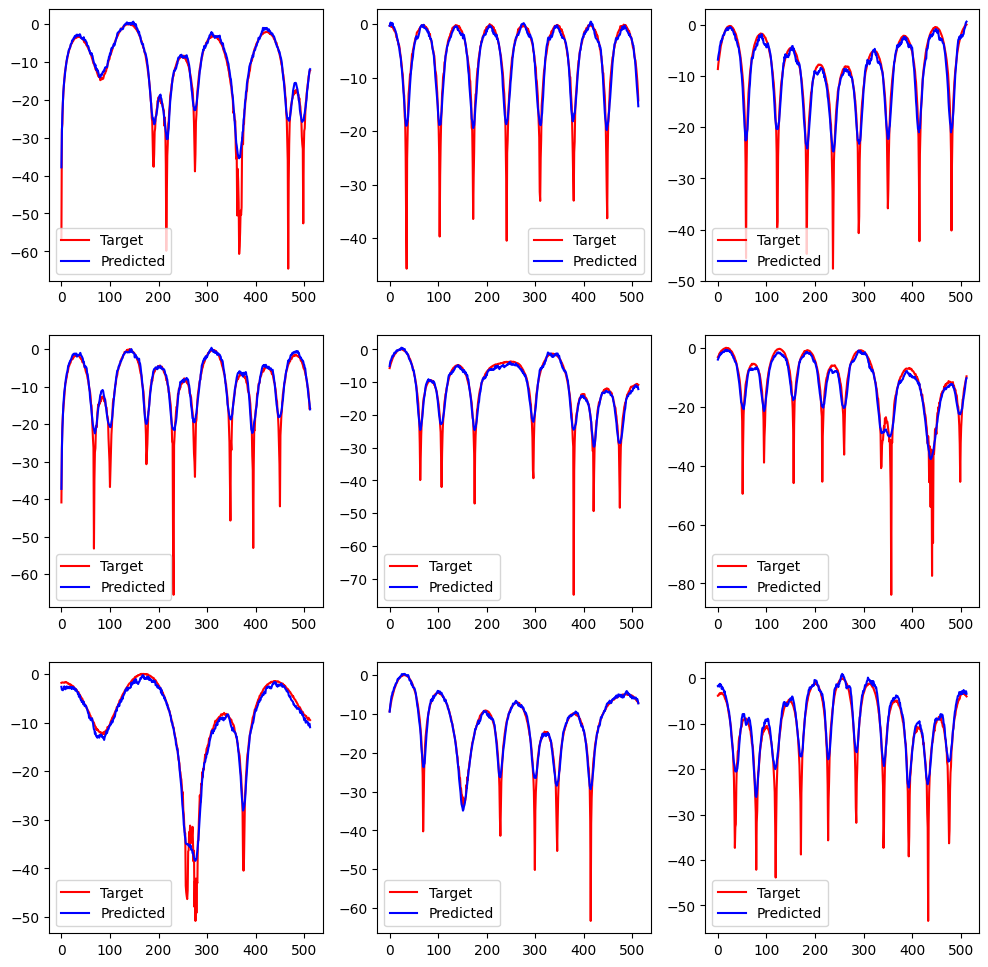

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
ax = ax.ravel()
for i in range(9):
    ax[i].plot(y_test[i], 'r', label='Target')
    ax[i].plot(np.array(model(np.array([x_test[i]]))).reshape(-1), 'b', label='Predicted')
    ax[i].legend()
plt.show()

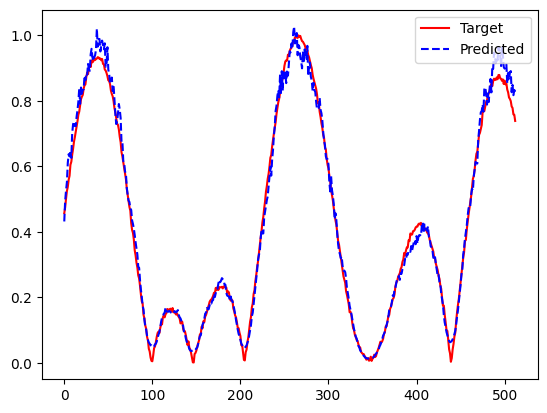

In [13]:
plt.plot(10**(y_test[9]/20), 'r', label='Target')
plt.plot(10**(np.array(model(np.array([x_test[9]]))).reshape(-1)/20), 'b--', label='Predicted')
plt.legend()
plt.show()

In [14]:
y_test.shape, np.array(model(np.array(x_test))).shape

((4000, 513, 1), (4000, 513))

In [15]:
metric_dB = R2Score()
metric_dB.update_state(np.squeeze(y_test, axis=2), np.array(model(np.array(x_test))))
result_dB = metric_dB.result()

In [16]:
result_dB

<tf.Tensor: shape=(), dtype=float32, numpy=0.8339155>

In [17]:
metric = R2Score()
metric.update_state(10**(np.squeeze(y_test, axis=2)/20), 10**(np.array(model(np.array(x_test)))/20))
result = metric.result()

In [18]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=0.9511488>

In [19]:
model.save("Babikov_model_FFT.h5")

In [ ]:
from tensorflow.keras.models import load_model
load_model("Babikov_model_FFT.h5")

In [20]:
from IPython.display import clear_output
import time

In [21]:
from IPython.display import clear_output
import time

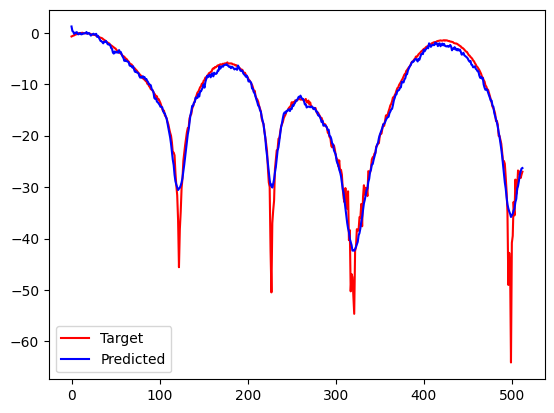

In [22]:
for _ in range(10):
  clear_output()
  x_t, y_t = generate_data(1, 1)
  plt.plot(y_t[0], 'r', label='Target')
  plt.plot(np.array(model(np.array(x_t))).reshape(-1), 'b', label='Predicted')
  plt.legend()
  plt.show()
  time.sleep(1)